# Protein Annotation Collection

To analyze and split proteins in BindingDB, we will collect annotations of proteins regarding family information and their functions. From UniProt, we will retrieve their ChEMBL ID, GO annotations and DrugBank entries to understanding tha data better. To split our data and construct a heldout test set, we need to obtain which families/clans the proteins in our data belong to. We will retrieve this from Pfam database using UniProt IDs of these proteins.  

In [46]:
import pandas as pd
import requests
import re
import json
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm.autonotebook import tqdm
tqdm.pandas()
sns.set()

In [2]:
proteins = pd.read_csv("../data/BindingDB_onechain_protein_seq.csv")
uniprot_ids = list(set(proteins['UniProt_S_ID'].values.tolist()))
proteins.shape

(5469, 1)

## PFAM families

Here is the code to scrape the Pfam page given protein UniProt ID

In [113]:
pfam_url_format = 'http://pfam.xfam.org/protein/{}'

def get_pfam_families(uniprot_id):
    txt = str(requests.get(pfam_url_format.format(uniprot_id)).content)
    ptrn1 =  re.compile(r'<table.+?summary=\"Key for the Pfam domain image\"(.+?)<\/table>', re.MULTILINE)
    table = ptrn1.search(txt)
    table = table.group(1) if table else ''
    ptrn = re.compile(r'<td class=\"pfama_(.+?)\">Pfam<\/td>.+?<td><a.+?>(.+?)<\/a><\/td>.+?<td>(\d+)<\/td>.+?<td>(\d+)<\/td>', re.MULTILINE)
    return ptrn.findall(table)

get_pfam_families('P51878')

[('PF00619', 'CARD', '61', '146'), ('PF00656', 'Peptidase_C14', '193', '430')]

In [114]:
families = {}

We collect the Pfam families of the proteins.

In [ ]:
for uid in tqdm(uniprot_ids):
    if uid not in families:
        families[uid] = get_pfam_families(uid)

In [ ]:
with open('../data/BDB_onechain_proteins_with_families.json', 'w') as f:
    json.dump(families, f)

## ChEMBL ID, DrugBank, GO annotations from UniProt

In [3]:
uniprot_format = 'https://www.uniprot.org/uniprot/{}.txt'
def collect_from_uniprot(uniprot_id):
    txt = str(requests.get(uniprot_format.format(uniprot_id)).content)
    ChEMBL_id = re.search(r'DR   ChEMBL;(.+?);', txt)
    drugbank_entries = re.findall(r'DR   DrugBank;(.+?);(.+?)\.', txt)
    go_annotations = re.findall(r'DR   GO;(.+?);(.+?);.+?\.', txt)
    return {'ChEMBL': ChEMBL_id.group(1).strip() if ChEMBL_id else 'None', 
            'DrugBank': {d_id.strip(): d_name.strip() for (d_id, d_name) in drugbank_entries},
            'GO_annotations': {go_id.strip(): go_name.strip() for (go_id, go_name) in go_annotations}}

collect_from_uniprot('Q9UKV0')    

{'ChEMBL': 'CHEMBL4145',
 'DrugBank': {'DB05015': 'Belinostat',
  'DB06603': 'Panobinostat',
  'DB00313': 'Valproic acid'},
 'GO_annotations': {'GO:0005737': 'C:cytoplasm',
  'GO:0000118': 'C:histone deacetylase complex',
  'GO:0035097': 'C:histone methyltransferase complex',
  'GO:0005654': 'C:nucleoplasm',
  'GO:0005634': 'C:nucleus',
  'GO:0005667': 'C:transcription regulator complex',
  'GO:0004407': 'F:histone deacetylase activity',
  'GO:0034739': 'F:histone deacetylase activity (H4-K16 specific)',
  'GO:0042826': 'F:histone deacetylase binding',
  'GO:0046872': 'F:metal ion binding',
  'GO:0032041': 'F:NAD-dependent histone deacetylase activity (H3-K14 specific)',
  'GO:0033558': 'F:protein deacetylase activity',
  'GO:0005080': 'F:protein kinase C binding',
  'GO:0070491': 'F:repressing transcription factor binding',
  'GO:0003714': 'F:transcription corepressor activity',
  'GO:0008134': 'F:transcription factor binding',
  'GO:0042113': 'P:B cell activation',
  'GO:0030183': 'P

In [4]:
uniprot_data = {}

In [ ]:
for uid in tqdm(uniprot_ids):
    if uid not in uniprot_data:
        uniprot_data[uid] = collect_from_uniprot(uid)

In [ ]:
with open('../data/BDB_onechain_proteins_uniprot.json', 'w') as f:
    json.dump(uniprot_data, f)

## Format collected information

In [36]:
# To be deleted
with open('../data/old/BDB_onechain_proteins_with_go.json') as f:
    go = json.loads(f.read())
with open('../data/old/BDB_onechain_proteins_chembl_drugbank.json') as f:
    chembl = json.loads(f.read())    
with open('../data/old/BDB_onechain_proteins_with_families.json') as f:
    fam = json.loads(f.read())     
    
uniprot_data = {key: {'GO_annotations': value, **chembl[key]} for key, value in go.items()}
families = {key: [tuple(item.values()) for item in value] if value else '' for key, value in fam.items() }
with open('../data/BDB_onechain_proteins_with_families.json', 'w') as f:
    json.dump(families, f)

In [12]:
def family_info(uniprot_id):
    return families[uniprot_id]
proteins['families'] = proteins['UniProt_S_ID'].apply(family_info)

In [16]:
def format_uniprot_data(uniprot_id):
    protein_data = uniprot_data[uniprot_id]
    if protein_data is not None:
        drugbank = [(k, v) for k, v in protein_data['DrugBank'].items()]
        go_component = [(k, v) for k, v in protein_data['GO_annotations'].items() if v.startswith('C:')]
        go_function = [(k, v) for k, v in protein_data['GO_annotations'].items() if v.startswith('F:')]
        go_process = [(k, v) for k, v in protein_data['GO_annotations'].items() if v.startswith('P:')]
        return protein_data['ChEMBL'], drugbank, go_component, go_function, go_process
    drugbank_id, drugbank_names  
    return None

proteins['ChEMBL_ID'], proteins['DrugBank'], proteins['GO_Component'],  proteins['GO_Function'],  proteins['GO_Process'] = zip(*proteins['UniProt_S_ID'].apply(format_uniprot_data))

In [18]:
proteins.head()

,UniProt_S_ID,families,ChEMBL_ID,DrugBank,GO_Component,GO_Function,GO_Process
0,P08684,"[(PF00067, p450, 38, 493)]",CHEMBL340,"[(DB08496, (R)-warfarin.), (DB14055, (S)-Warfa...","[(GO:0005737, C:cytoplasm), (GO:0005789, C:end...","[(GO:0102320, F:1,8-cineole 2-exo-monooxygenas...","[(GO:0009822, P:alkaloid catabolic process), (..."
1,P51570,"[(PF10509, GalKase_gal_bdg, 18, 67), (PF00288,...",CHEMBL1293257,"[(DB04395, Phosphoaminophosphonic Acid-Adenyla...","[(GO:0005737, C:cytoplasm), (GO:0005829, C:cyt...","[(GO:0005524, F:ATP binding), (GO:0004335, F:g...","[(GO:0019402, P:galactitol metabolic process),..."
2,P42574,"[(PF00656, Peptidase_C14, 45, 275)]",CHEMBL2334,"[(DB08498, (1S)-1-(3-chlorophenyl)-2-oxo-2-[(1...","[(GO:0005737, C:cytoplasm), (GO:0005829, C:cyt...","[(GO:0004190, F:aspartic-type endopeptidase ac...","[(GO:0006309, P:apoptotic DNA fragmentation), ..."
3,P29466,"[(PF00619, CARD, 3, 90), (PF00656, Peptidase_C...",CHEMBL4801,"[(DB07733, 1-METHYL-3-TRIFLUOROMETHYL-1H-THIEN...","[(GO:0097169, C:AIM2 inflammasome complex), (G...","[(GO:0050700, F:CARD domain binding), (GO:0008...","[(GO:0006915, P:apoptotic process), (GO:007134..."
4,P49662,"[(PF00619, CARD, 3, 87), (PF00656, Peptidase_C...",CHEMBL2226,[],"[(GO:0097169, C:AIM2 inflammasome complex), (G...","[(GO:0050700, F:CARD domain binding), (GO:0004...","[(GO:0006915, P:apoptotic process), (GO:190464..."


Pfam family-clan mapping is downloaded from the following link: ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam33.1/Pfam-A.clans.tsv.gz

In [19]:
clans = pd.read_csv('../data/Pfam-A.clans.tsv', sep='\t', header=None, names=["family_id", "clan_id", "clan_name", "family_short", "family_name"])

In [77]:
clans.dropna(subset=['clan_id'], inplace=True)

In [78]:
fam_id_to_clan =  clans[['family_id', 'clan_id', 'clan_name']].set_index('family_id').T.to_dict('list')
fam_id_to_clan

{'PF00001': ['CL0192', 'GPCR_A'],
 'PF00002': ['CL0192', 'GPCR_A'],
 'PF00003': ['CL0192', 'GPCR_A'],
 'PF00004': ['CL0023', 'P-loop_NTPase'],
 'PF00005': ['CL0023', 'P-loop_NTPase'],
 'PF00006': ['CL0023', 'P-loop_NTPase'],
 'PF00007': ['CL0079', 'Cystine-knot'],
 'PF00008': ['CL0001', 'EGF'],
 'PF00009': ['CL0023', 'P-loop_NTPase'],
 'PF00011': ['CL0190', 'HSP20'],
 'PF00012': ['CL0108', 'Actin_ATPase'],
 'PF00013': ['CL0007', 'KH'],
 'PF00017': ['CL0541', 'SH2-like'],
 'PF00018': ['CL0010', 'SH3'],
 'PF00019': ['CL0079', 'Cystine-knot'],
 'PF00020': ['CL0607', 'TNF_receptor'],
 'PF00021': ['CL0117', 'uPAR_Ly6_toxin'],
 'PF00022': ['CL0108', 'Actin_ATPase'],
 'PF00023': ['CL0465', 'Ank'],
 'PF00024': ['CL0168', 'PAN'],
 'PF00025': ['CL0023', 'P-loop_NTPase'],
 'PF00026': ['CL0129', 'Peptidase_AA'],
 'PF00027': ['CL0029', 'Cupin'],
 'PF00028': ['CL0159', 'E-set'],
 'PF00029': ['CL0375', 'Transporter'],
 'PF00030': ['CL0333', 'gCrystallin'],
 'PF00031': ['CL0121', 'Cystatin'],
 'PF0003

In [79]:
def map_fams_to_clans(protein_families):
    return [tuple(fam_id_to_clan[fam[0]]) if fam[0] in fam_id_to_clan else '' for fam in protein_families]
map_fams_to_clans(proteins.iloc[1].families)

[('CL0329', 'S5'), ('CL0329', 'S5'), ('CL0677', 'GHMP_C')]

In [80]:
proteins['clans'] = proteins['families'].apply(map_fams_to_clans)

In [81]:
proteins.head()

,UniProt_S_ID,families,ChEMBL_ID,DrugBank,GO_Component,GO_Function,GO_Process,clans
0,P08684,"[(PF00067, p450, 38, 493)]",CHEMBL340,"[(DB08496, (R)-warfarin.), (DB14055, (S)-Warfa...","[(GO:0005737, C:cytoplasm), (GO:0005789, C:end...","[(GO:0102320, F:1,8-cineole 2-exo-monooxygenas...","[(GO:0009822, P:alkaloid catabolic process), (...",[]
1,P51570,"[(PF10509, GalKase_gal_bdg, 18, 67), (PF00288,...",CHEMBL1293257,"[(DB04395, Phosphoaminophosphonic Acid-Adenyla...","[(GO:0005737, C:cytoplasm), (GO:0005829, C:cyt...","[(GO:0005524, F:ATP binding), (GO:0004335, F:g...","[(GO:0019402, P:galactitol metabolic process),...","[(CL0329, S5), (CL0329, S5), (CL0677, GHMP_C)]"
2,P42574,"[(PF00656, Peptidase_C14, 45, 275)]",CHEMBL2334,"[(DB08498, (1S)-1-(3-chlorophenyl)-2-oxo-2-[(1...","[(GO:0005737, C:cytoplasm), (GO:0005829, C:cyt...","[(GO:0004190, F:aspartic-type endopeptidase ac...","[(GO:0006309, P:apoptotic DNA fragmentation), ...","[(CL0093, Peptidase_CD)]"
3,P29466,"[(PF00619, CARD, 3, 90), (PF00656, Peptidase_C...",CHEMBL4801,"[(DB07733, 1-METHYL-3-TRIFLUOROMETHYL-1H-THIEN...","[(GO:0097169, C:AIM2 inflammasome complex), (G...","[(GO:0050700, F:CARD domain binding), (GO:0008...","[(GO:0006915, P:apoptotic process), (GO:007134...","[(CL0041, Death), (CL0093, Peptidase_CD)]"
4,P49662,"[(PF00619, CARD, 3, 87), (PF00656, Peptidase_C...",CHEMBL2226,[],"[(GO:0097169, C:AIM2 inflammasome complex), (G...","[(GO:0050700, F:CARD domain binding), (GO:0004...","[(GO:0006915, P:apoptotic process), (GO:190464...","[(CL0041, Death), (CL0093, Peptidase_CD)]"


In [34]:
proteins.to_csv('BindingDB_1chain_proteins_all.csv', index=False)

## PFAM Family Analysis

In [37]:
protein_families = proteins.explode('families').reset_index(drop=True)
protein_families_uniq = protein_families[['UniProt_S_ID', 'families']].drop_duplicates()
protein_families_uniq.head()

,UniProt_S_ID,families
0,P08684,"(PF00067, p450, 38, 493)"
1,P51570,"(PF10509, GalKase_gal_bdg, 18, 67)"
2,P51570,"(PF00288, GHMP_kinases_N, 126, 194)"
3,P51570,"(PF08544, GHMP_kinases_C, 291, 374)"
4,P42574,"(PF00656, Peptidase_C14, 45, 275)"


In [48]:
protein_families_uniq['family_id'] = protein_families_uniq['families'].apply(lambda x: x[0] if x else '')
family_counts = protein_families_uniq.groupby('family_id').count()
print('Number of families', protein_families_uniq['family_id'].nunique())
family_counts.sort_values(by='UniProt_S_ID', ascending=False).head()

Number of families 2239


,UniProt_S_ID,families
family_id,,
PF00001,601,601
PF00069,405,405
PF00520,251,251
PF07714,193,193
PF00008,139,139


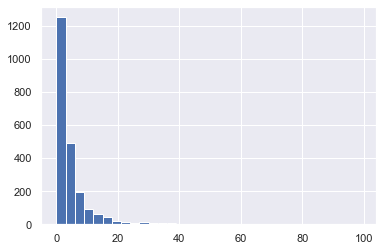

In [54]:
family_counts['UniProt_S_ID'].hist(bins=np.arange(0, 100, 3))

## PFAM Clan Analysis

In [82]:
protein_clans = proteins.explode('clans').reset_index(drop=True)
protein_clans_uniq = protein_clans[['UniProt_S_ID', 'clans']].drop_duplicates()
protein_clans_uniq.head()

,UniProt_S_ID,clans
0,P08684,
1,P51570,"(CL0329, S5)"
3,P51570,"(CL0677, GHMP_C)"
4,P42574,"(CL0093, Peptidase_CD)"
5,P29466,"(CL0041, Death)"


In [99]:
clan_counts = protein_clans_uniq.groupby('clans').count()
print('Number of clans', protein_clans_uniq['clans'].nunique())
clan_counts.sort_values(by='UniProt_S_ID', ascending=False)[:20]

Number of clans 371


,UniProt_S_ID
clans,
,1994
"(CL0192, GPCR_A)",673
"(CL0016, PKinase)",620
"(CL0063, NADP_Rossmann)",241
"(CL0023, P-loop_NTPase)",209
"(CL0030, Ion_channel)",183
"(CL0124, Peptidase_PA)",132
"(CL0159, E-set)",131
"(CL0167, Zn_Beta_Ribbon)",107


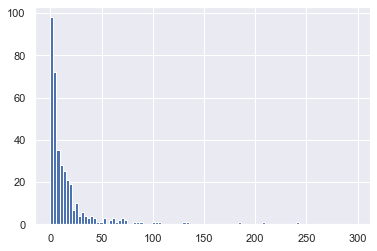

In [98]:
clan_counts['UniProt_S_ID'].hist(bins=np.arange(0, 300, 3))

## GO Analysis

In [101]:
protein_go_c = proteins.explode('GO_Component').reset_index(drop=True)
protein_go_c_uniq = protein_go_c[['UniProt_S_ID', 'GO_Component']].drop_duplicates()
protein_go_c_uniq.head()

,UniProt_S_ID,GO_Component
0,P08684,"(GO:0005737, C:cytoplasm)"
1,P08684,"(GO:0005789, C:endoplasmic reticulum membrane)"
2,P08684,"(GO:0016021, C:integral component of membrane)"
3,P08684,"(GO:0043231, C:intracellular membrane-bounded ..."
4,P51570,"(GO:0005737, C:cytoplasm)"


In [103]:
protein_go_c_counts = protein_go_c_uniq.groupby('GO_Component').count()
print('Number of GO Components', protein_go_c_uniq['GO_Component'].nunique())
protein_go_c_counts.sort_values(by='UniProt_S_ID', ascending=False)[:20]

Number of GO Components 1185


,UniProt_S_ID
GO_Component,
"(GO:0005886, C:plasma membrane)",1996
"(GO:0005737, C:cytoplasm)",1859
"(GO:0005829, C:cytosol)",1635
"(GO:0005634, C:nucleus)",1326
"(GO:0016021, C:integral component of membrane)",1021
"(GO:0005887, C:integral component of plasma membrane)",984
"(GO:0005654, C:nucleoplasm)",866
"(GO:0016020, C:membrane)",811
"(GO:0005576, C:extracellular region)",582


In [107]:
protein_go_c_counts.sort_values(by='UniProt_S_ID', ascending=True)[:20]

,UniProt_S_ID
GO_Component,
"(GO:1990917, C:ooplasm)",1
"(GO:0014701, C:junctional sarcoplasmic reticulum membrane)",1
"(GO:0043332, C:mating projection tip)",1
"(GO:0043509, C:activin A complex)",1
"(GO:0043512, C:inhibin A complex)",1
"(GO:0043540, C:6-phosphofructo-2-kinase/fructose-2,6-biphosphatase complex)",1
"(GO:0043596, C:nuclear replication fork)",1
"(GO:0043626, C:PCNA complex)",1
"(GO:0043655, C:host extracellular space)",1


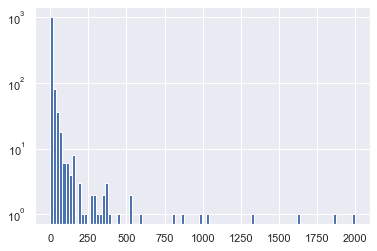

In [106]:
protein_go_c_counts['UniProt_S_ID'].hist(bins=100, log=True)

In [108]:
protein_go_f = proteins.explode('GO_Function').reset_index(drop=True)
protein_go_f_uniq = protein_go_f[['UniProt_S_ID', 'GO_Function']].drop_duplicates()
protein_go_f_uniq.head()

,UniProt_S_ID,GO_Function
0,P08684,"(GO:0102320, F:1,8-cineole 2-exo-monooxygenase..."
1,P08684,"(GO:0070330, F:aromatase activity)"
2,P08684,"(GO:0034875, F:caffeine oxidase activity)"
3,P08684,"(GO:0019899, F:enzyme binding)"
4,P08684,"(GO:0101020, F:estrogen 16-alpha-hydroxylase a..."


In [139]:
protein_go_f[protein_go_f['GO_Function'].astype(str).str.contains('GO:0043027')]

,UniProt_S_ID,families,ChEMBL_ID,DrugBank,GO_Component,GO_Function,GO_Process,clans
805,Q13489,"[(PF00653, BIR, 32, 97), (PF00653, BIR, 172, 2...",CHEMBL5335,[],"[(GO:0005737, C:cytoplasm), (GO:0005829, C:cyt...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0007166, P:cell surface receptor signalin...","[(CL0417, BIR-like), (CL0417, BIR-like), (CL04..."
3407,Q15418,"[(PF00069, Pkinase, 62, 321), (PF00433, Pkinas...",CHEMBL2553,"[(DB12010, Fostamatinib.), (DB04751, Purvalano...","[(GO:0005829, C:cytosol), (GO:0005654, C:nucle...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0007049, P:cell cycle), (GO:0072574, P:he...","[(CL0016, PKinase), , (CL0016, PKinase)]"
3413,P51812,"[(PF00069, Pkinase, 68, 327), (PF00433, Pkinas...",CHEMBL2345,"[(DB00945, Acetylsalicylic acid.), (DB12010, F...","[(GO:0005829, C:cytosol), (GO:0005654, C:nucle...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0007049, P:cell cycle), (GO:0007417, P:ce...","[(CL0016, PKinase), , (CL0016, PKinase)]"
4237,P98170,"[(PF00653, BIR, 29, 94), (PF00653, BIR, 166, 2...",CHEMBL4198,"[(DB02628, 1-[3,3-Dimethyl-2-(2-Methylamino-Pr...","[(GO:0005737, C:cytoplasm), (GO:0005829, C:cyt...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0006974, P:cellular response to DNA damag...","[(CL0417, BIR-like), (CL0417, BIR-like), (CL04..."
4642,P16444,"[(PF01244, Peptidase_M19, 25, 352)]",CHEMBL1989,"[(DB01597, Cilastatin.), (DB06211, Doripenem.)...","[(GO:0031225, C:anchored component of membrane...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0016999, P:antibiotic metabolic process),...","[(CL0034, Amidohydrolase)]"
7013,P22412,"[(PF01244, Peptidase_M19, 25, 352)]",CHEMBL2626,[],"[(GO:0031225, C:anchored component of membrane...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0016999, P:antibiotic metabolic process),...","[(CL0034, Amidohydrolase)]"
7641,P49407,"[(PF00339, Arrestin_N, 18, 174), (PF02752, Arr...",CHEMBL1795088,[],"[(GO:0016323, C:basolateral plasma membrane), ...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0000187, P:activation of MAPK activity), ...","[(CL0135, Arrestin_N-like), (CL0135, Arrestin_..."
10550,Q64373,"[(PF02180, BH4, 1, 26), (PF00452, Bcl-2, 90, 1...",CHEMBL3309112,[],"[(GO:0097136, C:Bcl-2 family protein complex),...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0071839, P:apoptotic process in bone marr...","[, (CL0551, BCLiA)]"
10968,Q13490,"[(PF00653, BIR, 49, 114), (PF00653, BIR, 187, ...",CHEMBL5462,[],"[(GO:0035631, C:CD40 receptor complex), (GO:00...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0007166, P:cell surface receptor signalin...","[(CL0417, BIR-like), (CL0417, BIR-like), (CL04..."
11603,P37840,"[(PF01387, Synuclein, 1, 131)]",CHEMBL6152,"[(DB09130, Copper.), (DB02709, Resveratrol.)]","[(GO:0015629, C:actin cytoskeleton), (GO:00304...","(GO:0043027, F:cysteine-type endopeptidase inh...","[(GO:0006919, P:activation of cysteine-type en...",[]


In [110]:
protein_go_f_counts = protein_go_f_uniq.groupby('GO_Function').count()
print('Number of GO Function', protein_go_f_uniq['GO_Function'].nunique())
protein_go_f_counts.sort_values(by='UniProt_S_ID', ascending=False)[:20]

Number of GO Function 3035


,UniProt_S_ID
GO_Function,
"(GO:0005524, F:ATP binding)",1122
"(GO:0042802, F:identical protein binding)",869
"(GO:0046872, F:metal ion binding)",743
"(GO:0008270, F:zinc ion binding)",481
"(GO:0004930, F:G protein-coupled receptor activity)",407
"(GO:0004674, F:protein serine/threonine kinase activity)",395
"(GO:0042803, F:protein homodimerization activity)",366
"(GO:0003677, F:DNA binding)",279
"(GO:0044877, F:protein-containing complex binding)",263


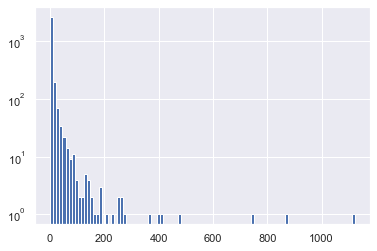

In [111]:
protein_go_f_counts['UniProt_S_ID'].hist(bins=100, log=True)